# Week 07 Exercises 

### 7.1 Calculating the Normalized Difference Index
From [https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index](https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index)... the Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health. NDVI is calculated as a ratio between the red (R) and near infrared (NIR) values in traditional fashion: 

(NIR - R) / (NIR + R)

NDVI always ranges from -1 to +1. But there isn’t a distinct boundary for each type of land cover.For example, when you have negative values, it’s highly likely that it’s water. On the other hand, if you have an NDVI value close to +1, there’s a high possibility that it’s dense green leaves. But when NDVI is close to zero, there are likely no green leaves and it could even be an urbanized area.

For this first exercise you will calculate NDVI over the LMU campus.

1. Load both red (``` 'data/2023-02-22-sentinel-2-red-band.tiff' ```) and NIR (``` 'data/2023-02-22-sentinel-2-NIR-band.tiff' ```) bands from images taken from Sentinel-2 satellite over the LMU campus on February 22, 2023. Make sure when loading to use ```masked=True ```. Why do we want to do this? Check to see if the bounds, resolution and CRS are the same for both datasets. 


In [8]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping


# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
# Define relative path to file
red_path = os.path.join("data","2023-02-22-sentinel-2-red-band.tiff")
NIR_path = os.path.join("data","2023-02-22-sentinel-2-NIR-band.tiff")

In [9]:
red_xr = rxr.open_rasterio(red_path, masked=True).squeeze()
red_xr

<xarray.DataArray (y: 140, x: 159)>
[22260 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -118.4 -118.4 -118.4 ... -118.4 -118.4 -118.4
  * y            (y) float64 33.98 33.97 33.97 33.97 ... 33.96 33.96 33.96 33.96
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [10]:
NIR_xr = rxr.open_rasterio(NIR_path, masked=True).squeeze()
NIR_xr

<xarray.DataArray (y: 140, x: 159)>
[22260 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -118.4 -118.4 -118.4 ... -118.4 -118.4 -118.4
  * y            (y) float64 33.98 33.97 33.97 33.97 ... 33.96 33.96 33.96 33.96
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [26]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      red_xr.rio.bounds() == NIR_xr.rio.bounds())

# Is the resolution the same?
print("Is the resolution the same?",
      red_xr.rio.resolution() == NIR_xr.rio.resolution())

# Is the CRS the same?
print("The crs is", red_xr.rio.crs)
print("The crs is", NIR_xr.rio.crs)

Is the spatial extent the same? True
Is the resolution the same? True
The crs is EPSG:4326
The crs is EPSG:4326


It is important to ensure that masked=True to ensure that no data values do not plot, and are appropriately assigned NaN or nodata. Based on the xarray.DataArray (y,x), number of values, resolution, and index it can also be seen that the datasets match. 

2. Calculate the NDVI. Export and save to a file as ``` 'data/2023-02-22-sentinel-2-NDVI.tiff' ```

In [12]:
NDVI_xr = (NIR_xr - red_xr)/(NIR_xr + red_xr)
NDVI_path = os.path.join("data","2023-02-22-sentinel-2-NDVI.tiff")

if os.path.exists(NDVI_path):
    print("The directory", NDVI_path, "exists!")
else:
    os.makedirs(NDVI_path)

The directory data/2023-02-22-sentinel-2-NDVI.tiff exists!


3. Plot the NDVI data using the colormap ```RdYlGn```. Write 1-2 sentences describing patterns you notice.

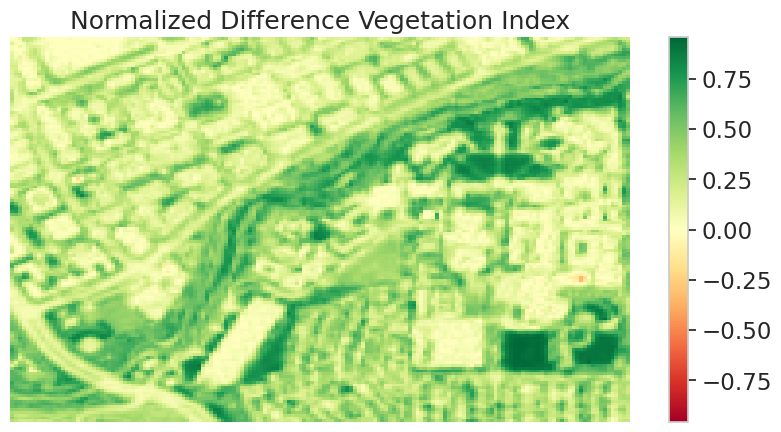

In [13]:
# Plot the data
f, ax = plt.subplots(figsize=(10, 5))
NDVI_xr.plot(cmap="RdYlGn")
ax.set(title="Normalized Difference Vegetation Index")
ax.set_axis_off()
plt.show()

Based upon this map, the NDVI is between about 0-0.5 for the region on average, peaking around 1 in specific areas. This means that LMU campus is likely an urbanized area with a few lush areas.

4. Create a histogram with the custom bins: ```  bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1] ```. Write 1-2 sentences explaining patterns you notice. Lastly, print the max and min values. 

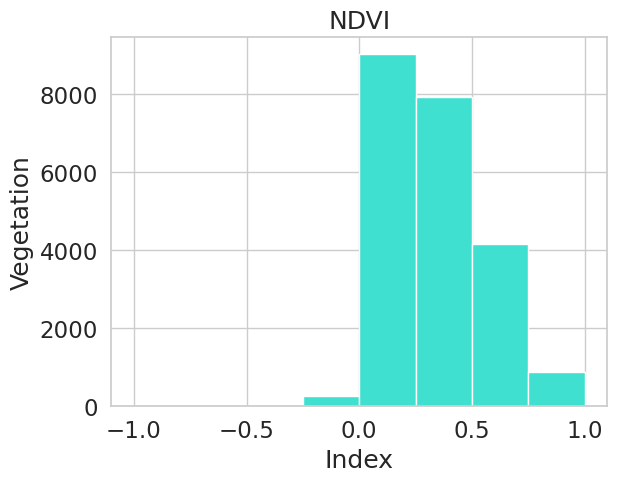

In [25]:
f, ax = plt.subplots()
NDVI_xr.plot.hist(color="turquoise",
                        bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
ax.set(title="NDVI",
       xlabel="Index",
       ylabel="Vegetation")

plt.show()

Based upon this histogram, LMU's campus area falls around 0.25 indicating an urbanized area as shown on the plot above. 

In [15]:
print('NDVI minimum value: ', np.nanmin(NDVI_xr))
print('NDVI max value: ', np.nanmax(NDVI_xr))

NDVI minimum value:  -0.3420191
NDVI max value:  0.95758915


### 7.2  Manually Reclassify NDVI Data
Buildling on 7.1, let's now reclassify the NDVI data to more meaningful symbologies. 

1. Use the following breaks to reclassify the NDVI data:
- <0: water 
- 0 to 0.2: urban/barren
- 0.2 to 0.5: low vegetation
- $\gt$ 0.5: high vegetation

Note that you **do not** have to do any additional masking as your NoData mask already occured when loading in the data. 


In [16]:
NDVI_xr.rio.nodata

class_bins = [-np.inf, 0, 0.2, 0.5, np.inf]
class_bins

[-inf, 0, 0.2, 0.5, inf]

In [17]:
NDVI_xr_class = xr.apply_ufunc(np.digitize,
                                     NDVI_xr,
                                     class_bins)

2. Plot the data using the following parameters:
- ```colors = ['blue', 'beige', 'green', 'darkgreen']```
- ```class_bins = [0.5, 1.5, 2.5, 3.5, 4.5]```

Write a few sentences of what you observe. Where does this classification scheme do well? Where does it not do well? Think of what you see walking around campus and how it compares to the map you generated. 

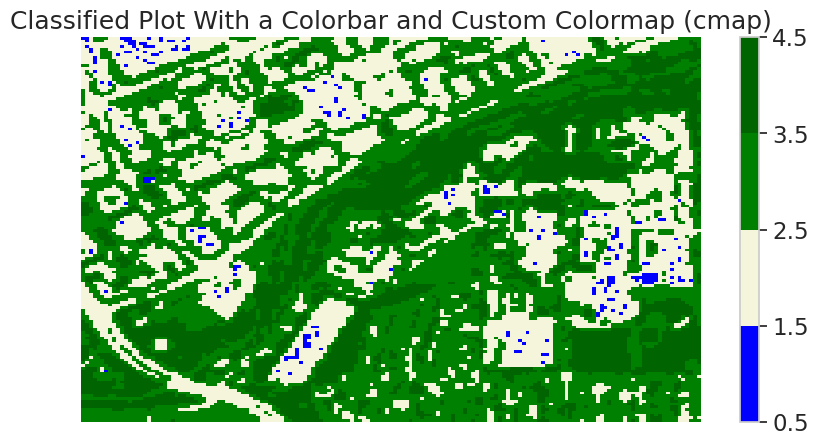

In [18]:
colors = ['blue', 'beige', 'green', 'darkgreen']
class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
NDVI_xr_class.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()

Based off this graphical representation, it is clear which areas consist of water, which areas contain no vegetation, and which areas contain the most vegetation around LMU. This graph is more detailed than the previous graph, and is consistent with the areas around LMU I personally recall. It remains fairly pixelated and could use greater resolution, but provides a fair generalization of the area. 

3. Create a histogram of the classified NDVI data. Give rough approximations of the percentages of each cateogry (i.e. ~20% water, ~40% barren/urban land etc.)

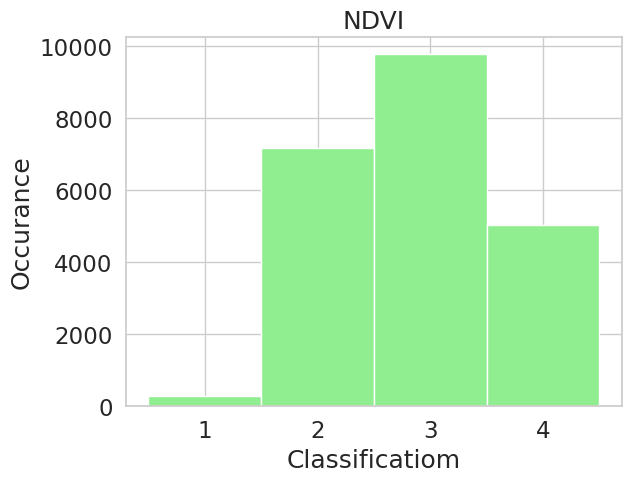

In [22]:
f, ax = plt.subplots()
NDVI_xr_class.plot.hist(color="lightgreen",
                        bins=[.5, 1.5, 2.5, 3.5, 4.5])
ax.set(title="NDVI",
       xlabel="Classificatiom",
       ylabel="Occurance")

plt.show()

~5% water
~30% urban/baren
~50% low vegetation
~15% high vegetation